# _littleglyphs_ - siamese network training

### Setup the environment

Import the project library for glyph generation, classification, plotting, etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import littleglyphs as lilg
import littleglyphs.plotting as lilgplt
import littleglyphs.classification as lilgcls
import littleglyphs.examples as lilgex
import littleglyphs.generation as lilggen

import importlib
importlib.reload(lilg)
importlib.reload(lilgplt)
importlib.reload(lilgcls)
importlib.reload(lilgex)
importlib.reload(lilggen)

/home/incide/miniconda3/envs/py36_for_tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/incide/miniconda3/envs/py36_for_tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/incide/miniconda3/envs/py36_for_tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/hom

<module 'littleglyphs.generation' from '/home/incide/projects/littleglyphs/littleglyphs/generation.py'>

Import the libraries required for this notebook.

In [3]:
import copy
import time

import numpy as np
import scipy
from scipy import signal as scipy_signal
import skimage
import sklearn 
import matplotlib.pyplot as plt

import tensorflow as tf
import keras


Some examples generate data randomly. Seed the random number generator for consistent results.

In [4]:
random_seed = 456
np.random.seed(random_seed)

### Broadly search glyph space

Pre-generate a large glyph alphabet to make sure that the siamese classifier has a large variety of glyphs to work from.

In [33]:
# How many glyphs in total do we want in our alphabet
N_glyphs_in_alphabet = 120

# How many slight variations of each glyph do we want
N_glyph_permutations = 5
permutation_strength = 0.08

# What parameters to use to generate glyph images
imgsize = 16

# What parameters to use to distort generated images
N_glyph_raster_distortions = 5
rotat_distort_max = np.pi / 6
shear_distort_max = np.pi / 12
scale_distort_max = 0.25

blur_factor = 1


time_start = time.time()
print('Generating glyph alphabet and rasters... ', end='')

alphabet_generator = lilgex.basic_random_glyph_generator()

glyph_categories = list(range(0,N_glyphs_in_alphabet))
glyph_alphabet = alphabet_generator.generate_random_glyph_alphabet(glyph_categories)
glyph_permuted_alphabet = glyph_alphabet.permuted(permutation_strength, N_glyph_permutations)

glyph_rasters = glyph_permuted_alphabet.render(
    (imgsize,imgsize), 
    blur_factor=blur_factor,randomize_blur=True,random_blur_extent=2
)
distorter = lilg.SequentialDistorter(
    [lilg.DistortionRandomAffine(
        rotat_distort_max = rotat_distort_max, 
        shear_distort_max = shear_distort_max,
        scale_distort_max = scale_distort_max
    )])
glyph_rasters = glyph_rasters.distorted(distorter, N_glyph_raster_distortions)

time_end = time.time()
print('done in '+'{0:.3f}'.format(time_end-time_start)+' sec '+
     '('+'{0:.3f}'.format((time_end-time_start)/N_glyphs_in_alphabet)+' sec per glyph).')


Generating glyph alphabet and rasters... done in 5.795 sec (0.048 sec per glyph).


Visualize the glyphs and show some examples of glyph rasters.

Ground truth glyphs:


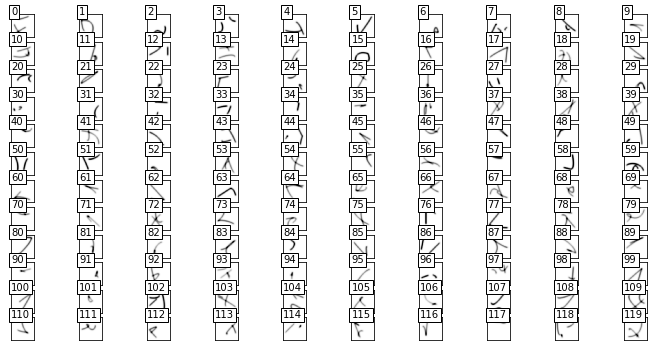

In [16]:
print('Ground truth glyphs:')
fig, axs = lilgplt.visualize_glyph_list(
    glyph_alphabet,
    N_glyphs_to_show = N_glyphs_in_alphabet, 
    imgsize=128, 
    blur_factor=0.5*16,
    figsize=(12,6)
)
plt.show()

Examples of glyph images:


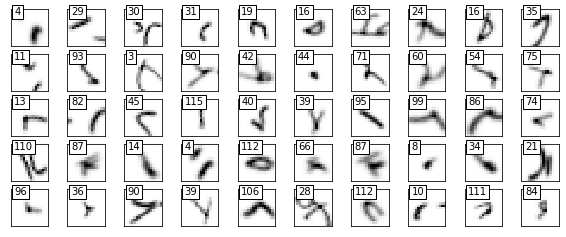

In [6]:
print('Examples of glyph images:')
N_images_to_show = 50

random_indices = np.arange(len(glyph_rasters))
np.random.shuffle(random_indices)
vis_imgs = glyph_rasters[random_indices[0:N_images_to_show]]
vis_categories = glyph_rasters.categories[random_indices[0:N_images_to_show]]

_ = lilgplt.visualize_img_array(vis_imgs,vis_categories,N_images_to_show,figsize=(10,4))
plt.show()

### Make a Siamese Network with CNN feature extraction

Siamese networks are a method to construct a similarity function for pairs of inputs. Briefly, two inputs are independently treated by two feature extracting networks (e.g. CNNs for images). Usually the inputs and feature extracting networks are symmetric. 

Afterwards, the outputs are either 1) subtracted from each other and fed into a dense layer, or 2) directly fed into a dense layer.

Finally, the dense layer is connected to a single output node which provides a value in \[0,1\] - the value of resulting similarity function.

For training, the network is fed pairs of inputs that belong to the same class (labeled with 1) or to different classes (labeled with 0).

Links:

* the original whitepaper https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf - 
* a decent tutorial https://sorenbouma.github.io/blog/oneshot/

In [7]:
keras.backend.clear_session()

In [8]:
model = lilgcls.make_SiameseCNN_model(
    imgsize, N_glyphs_in_alphabet, 
    complexity = 16, dense_complexity = 8,
    CNN_dropout_strength = 0.25,
    dense_dropout_strength = 0.01
)

keras.utils.plot_model(model, to_file='model.png')
# model.count_params()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputA (InputLayer)             (None, 1, 16, 16)    0                                            
__________________________________________________________________________________________________
inputB (InputLayer)             (None, 1, 16, 16)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 256)          144576      inputA[0][0]                     
                                          

In [9]:
accurs = [0]
val_accurs = [0]
losses = [0]
val_losses = [0] 
epoch_numbers = [0]

Generate pairs of images: "random" pairs of two images from two random classes, and "identical" pairs of two images from the same class.

In [34]:
glyph_rasters_seen = np.zeros(len(glyph_rasters))

In [35]:
glyph_raster_indices_A, glyph_raster_indices_B = lilgcls.select_random_data_pair_indices_for_SiameseCNN(
    glyph_rasters,      
    glyph_rasters_seen, 
    N_glyphs_in_alphabet, 
    N_pairs_to_select = 12000 # approx.
)

In [36]:
X = np.array([glyph_rasters[glyph_raster_indices_A],glyph_rasters[glyph_raster_indices_B]])
X = X.transpose(1,0,2,3)
Y = (glyph_rasters.categories[glyph_raster_indices_A] == glyph_rasters.categories[glyph_raster_indices_B])
Y = Y.astype('float32')

X_train, Y_train, X_cv, Y_cv, X_test, Y_test = lilgcls.split_data_for_learning(
    X, Y, 
    crossval_proportion = 0.2, 
    test_proportion = 0.2, 
    random_seed=random_seed
)
print("X_train matrix shape: "+str(X_train.shape)+"; Y_train matrix shape: "+str(Y_train.shape))
print("X_test  matrix shape: "+str(X_test.shape )+"; Y_test  matrix shape: "+str(Y_test.shape ))
print("X_cv    matrix shape: "+str(X_cv.shape   )+"; Y_cv    matrix shape: "+str(Y_cv.shape   ))

X_train matrix shape: (7158, 2, 16, 16); Y_train matrix shape: (7158,)
X_test  matrix shape: (2386, 2, 16, 16); Y_test  matrix shape: (2386,)
X_cv    matrix shape: (2386, 2, 16, 16); Y_cv    matrix shape: (2386,)


In [37]:
N_epochs = 10

X_train_conv = lilgcls.prep_data_for_SiameseCNN_model(X_train, imgsize)
X_cv_conv = lilgcls.prep_data_for_SiameseCNN_model(X_cv, imgsize)

h = model.fit(
    {'inputA': X_train_conv[:,0], 'inputB': X_train_conv[:,1]},
    {'output': Y_train},
    epochs=N_epochs, batch_size=128, 
    verbose=2, 
    validation_data=(
        {'inputA': X_cv_conv[:,0], 'inputB': X_cv_conv[:,1]},
        {'output': Y_cv},
    )
)
accurs += h.history['acc']
val_accurs += h.history['val_acc']
losses += h.history['loss']
val_losses += h.history['val_loss']
epoch_numbers += [e + epoch_numbers[-1]+1 for e in h.epoch]


Train on 7158 samples, validate on 2386 samples
Epoch 1/10
 - 11s - loss: 0.4587 - acc: 0.7857 - val_loss: 0.4509 - val_acc: 0.8055
Epoch 2/10
 - 10s - loss: 0.4419 - acc: 0.7932 - val_loss: 0.4367 - val_acc: 0.8143
Epoch 3/10
 - 10s - loss: 0.4145 - acc: 0.8104 - val_loss: 0.3992 - val_acc: 0.8370
Epoch 4/10
 - 11s - loss: 0.4019 - acc: 0.8202 - val_loss: 0.4490 - val_acc: 0.8160
Epoch 5/10
 - 13s - loss: 0.3949 - acc: 0.8189 - val_loss: 0.3825 - val_acc: 0.8474
Epoch 6/10
 - 13s - loss: 0.3789 - acc: 0.8277 - val_loss: 0.4178 - val_acc: 0.8386
Epoch 7/10
 - 16s - loss: 0.3722 - acc: 0.8328 - val_loss: 0.3905 - val_acc: 0.8537
Epoch 8/10
 - 14s - loss: 0.3577 - acc: 0.8451 - val_loss: 0.3803 - val_acc: 0.8541
Epoch 9/10
 - 14s - loss: 0.3488 - acc: 0.8491 - val_loss: 0.3635 - val_acc: 0.8638
Epoch 10/10
 - 10s - loss: 0.3436 - acc: 0.8462 - val_loss: 0.3546 - val_acc: 0.8630


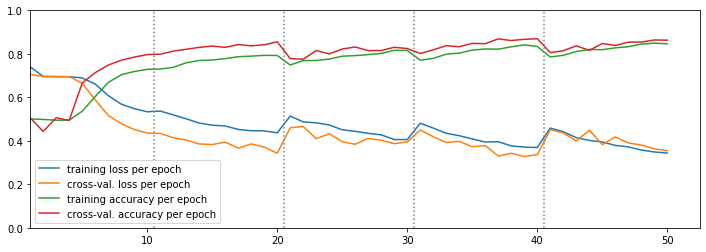

2386/2386 [==============================] - 1s 461us/step
Loss on test set: ~0.37
Accuracy on test set: ~85%


In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_numbers, losses, label='training loss per epoch')
plt.plot(epoch_numbers, val_losses, label='cross-val. loss per epoch')
plt.plot(epoch_numbers, accurs, label='training accuracy per epoch')
plt.plot(epoch_numbers, val_accurs, label='cross-val. accuracy per epoch')
ax.set_ylim([0,1])
ax.set_xlim([1,None])
ax.legend()
for i in range(0,epoch_numbers[-1]//N_epochs):
    plt.axvline(x=i*N_epochs+0.5,linestyle=':',color='Gray')
plt.show()

X_test_conv = lilgcls.prep_data_for_SiameseCNN_model(X_test,imgsize)
loss_and_metrics = model.evaluate(
    {'inputA': X_test_conv[:,0], 'inputB': X_test_conv[:,1]},
    {'output': Y_test},
    batch_size=128
)
print('Loss on test set: ~'+'{0:.2f}'.format(loss_and_metrics[0]))
print('Accuracy on test set: ~'+'{0:.0f}'.format(loss_and_metrics[1]*100)+'%')

In [39]:
import os
from datetime import datetime
nameprefix = 'siamese_CNN_model_'
epochsuffix = 'epoch'+str(epoch_numbers[-1])+'_'
timesuffix = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
model_save_dir = './saved_models/'
model_save_path = model_save_dir+nameprefix+epochsuffix+timesuffix+'.h5'

if not os.path.isdir(model_save_dir):
    os.makedirs(model_save_dir)
model.save(model_save_path)
print('Saved trained model at' + model_save_path)

Saved trained model at./saved_models/siamese_CNN_model_epoch50_2019-11-13-16-34-07.h5


### Classification

Classification via a Siamese network is a task of _O(N)_ complexity: you need to compare the tested image to every image in classification dataset.

For speedup, we classify the image by comparing it to a subsample of images from each class. Here lies an inherent risk: if the classes are highly heterogeneous, the subsample comparison might actually miss the some of the examples that are relevant for a proper classification of our test image. As an additional compromise we can repeat the classification several times with different subsamples, resulting in a task of _O(akp)_ complexity, where _a_ is the subsample size, _k_ is the amount of classes and _p_ is amount of attempts for classification with different subsamples.

First, load the classification model and give the classifier the model and support dataset.

In [6]:
# Use the notebook-generated model.
# model = model

In [6]:
# Use a saved pre-trained model.
model_dir = './saved_models/'
model_filename = 'siamese_CNN_model_epoch50_2019-11-09-16-35-54.h5'
model_path = model_dir + model_filename

# Loading model with Lambda layers (and any other custom functionality) requires feeding names. 
# This includes stuff that relies on backend if it wasn't imported via 'import keras.backend as K'.
# See https://github.com/keras-team/keras/issues/4609 for more workarounds.
model = keras.models.load_model(
    model_path, 
    custom_objects={
        'keras': keras,
        'keras.backend': keras.backend
    }
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.


In [13]:
siamese_classifier = lilgcls.SiameseCNN_classifier(model, glyph_rasters)

 Next, take a random image from the dataset as the "test" image.

Test image *should* be classified as belonging to category 106


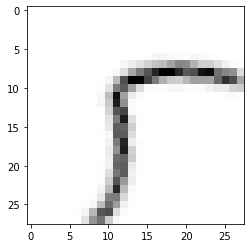

In [8]:
test_image_index = np.random.randint(glyph_rasters.N_rasters)
test_image = glyph_rasters[test_image_index]
plt.imshow(test_image, cmap='Greys')
print('Test image *should* be classified as belonging to category ' + 
      str(glyph_rasters.categories[test_image_index])
     )

Finally, produce the outputs.

NB: classification via a Siamese network results in a multi-hot vector! 

The meaning of each of the _k_ outputs in this vector is "how similar is this image to the images of class _k_". This also means that classes that the network considers to possess some similarity will likely have correlated outputs. 

Example: for classification of images as Arabic numbers, an attempt to classify an image of Latin letter G will likely give a strong output for number 6 ("G is similar to 6"). At the same time it will likely also give a medium-strength output for 0 ("G is kind of similar to 0", because of the rounded bit on the left), and for 2 and 4 ("G is kind of similar to 2 and to 4", because it has a horizontal line which numbers 2 and 4 also have).

This can be leveraged for extracting both inter-class confusion and general symbol familiarity:

* Performing a sum over the output gives a metric of likeness of the image to the examples of classes. The result answers the question "how similar is this image to all/any of the classes?" 
    * A high output sum means that the image is overall pretty similar to the classification dataset.
    * A low output sum means that the image is unlike anything in the classification dataset.
* Performing a softmax over the output gives a vector with the sum normalized to 1, similar to 1-hot encoding. The result answers the question "if you HAD to classify this image (whether it looks unfamiliar or not), how sure would you be that this image belongs to each of the classes?"

Classified as category 86


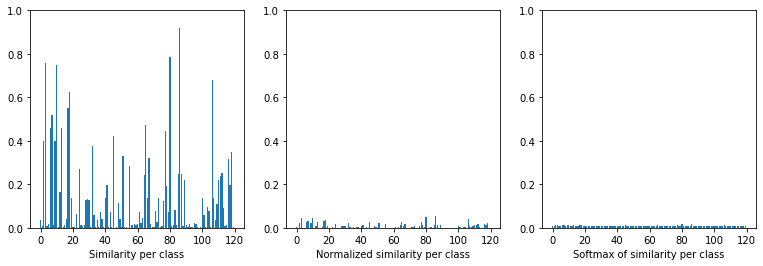

In [9]:
test_image_class_similarities = siamese_classifier.classify(
    test_image,
    subsample_size=3, subsample_attempts=5
)

fig,ax = plt.subplots(1,3,figsize=(13,4))
ax[0].bar(
    np.arange(0,glyph_rasters.N_different_categories,1),test_image_class_similarities
)
ax[0].set_ylim([0,1])
ax[0].set_xlabel("Similarity per class")
ax[1].bar(
    np.arange(0,glyph_rasters.N_different_categories,1),
    test_image_class_similarities/np.sum(test_image_class_similarities)
)
ax[1].set_ylim([0,1])
ax[1].set_xlabel("Normalized similarity per class")
ax[2].bar(
    np.arange(0,glyph_rasters.N_different_categories,1),scipy.special.softmax(test_image_class_similarities),
)
ax[2].set_ylim([0,1])
ax[2].set_xlabel("Softmax of similarity per class")

#ax1.xaxis.set_ticks(np.arange(0,glyph_rasters.N_different_categories,1)/glyph_rasters.N_different_categories)

test_image_output_category = np.argmax(test_image_class_similarities)
print('Classified as category '+str(test_image_output_category))

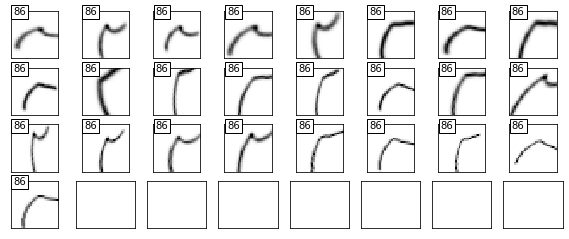

In [10]:
vis_rasters = glyph_rasters.select_category(test_image_output_category)
_ = lilgplt.visualize_img_array(
    vis_rasters.rasters, vis_rasters.categories, 
    vis_rasters.N_rasters,figsize=(10,4)
)

### Similarity and confusion matrices

Building a full confusion matrix for classification via a Siamese network is a difficult task of _O(N²)_ complexity: full confusion information requires looking at every possible pair of images in dataset.

By comparing random subsamples, we can partially simplify this task to _O((ak)²)_ complexity, where _k_ is number of classes and _a_ is an integer denoting subsample volume. Higher _a_ leads to better quality of information about the inter-class confusion of the model. Note that _a_ may have to be low for severely unbalanced models, if you have less than _a_ examples of a class. A workaround is balancing the classes by repeating the low-represented one multiple times.

(2, 57600, 28, 28)


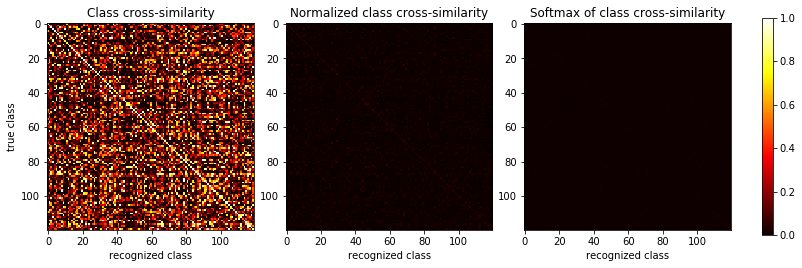

In [14]:
subsample_size = 2
similarity_matrix, Y_predicted = siamese_classifier.similarity_matrix(subsample_size)

similarity_matrix_norm = similarity_matrix.sum((0))
similarity_matrix_norm = np.divide(similarity_matrix,similarity_matrix_norm)

confusion_matrix = np.copy(Y_predicted)
confusion_matrix = confusion_matrix.reshape(
    glyph_rasters.N_different_categories,glyph_rasters.N_different_categories,subsample_size,subsample_size
)
confusion_matrix = scipy.special.softmax(confusion_matrix,axis=0)
confusion_matrix = confusion_matrix.mean((2,3))

fig,ax = plt.subplots(1,4,figsize=(13,4),gridspec_kw={"width_ratios":[1,1,1, 0.05]})
im = ax[0].imshow(similarity_matrix,vmin=0, vmax=1,cmap='hot')
ax[0].set_title("Class cross-similarity")
ax[0].set_ylabel("true class")
ax[0].set_xlabel("recognized class")
ax[1].imshow(similarity_matrix_norm,vmin=0, vmax=1,cmap='hot')
ax[1].set_title("Normalized class cross-similarity")
ax[1].set_ylabel("true class")
ax[1].set_xlabel("recognized class")
ax[2].imshow(confusion_matrix,vmin=0, vmax=1, cmap='hot')
ax[2].set_title("Softmax of class cross-similarity")
ax[2].set_ylabel("true class")
ax[2].set_xlabel("recognized class")
fig.colorbar(im,cax=ax[3])

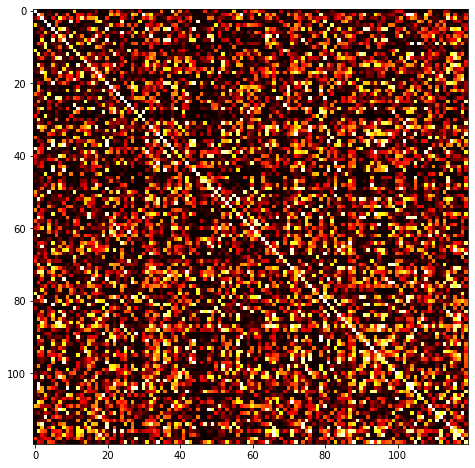

In [15]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(similarity_matrix,vmin=0, vmax=1,cmap='hot')